In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

import keras as ks
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from pandas_summary import DataFrameSummary

from tqdm import tqdm


Using TensorFlow backend.


In [3]:
from contextlib import contextmanager
import time

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('[{}] done in {:.0f} s'.format(name, time.time() - t0))

# with timer('process train'):
#     time.sleep(2.5)
#     pass


In [91]:
data_path = 'input/'
train = pd.read_csv(data_path +'train.csv', parse_dates=['listing_at'])
test = pd.read_csv(data_path +'test.csv', parse_dates=['listing_at'])

In [53]:
train.head()

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
0,7966,0.0,1164,1162,fff,Fair,7,2017-02-01 16:11:18.978516,3ca192bd7558780793444f73366c58d60c9d7775
1,1850,0.0,1005,1004,fff,Fair,3,2017-02-02 14:42:51.693295,fbaacb960902382e4f6c96f2d8f225c24eecadb4
2,7582,2.0,944,944,aaa,Fair,5,2017-02-03 01:55:53.406374,785a7925363bf133a7c5413c563f331c5e02cc69
3,6560,0.0,1068,1067,fff,Fair,7,2017-01-30 23:34:02.268603,f8997252c6e5ae3d950b736e1a81160a2e937a7f
4,7368,3.0,1407,1407,ddd,Good,15,2017-02-03 13:38:37.845010,ca59bcd3da4daac52f3fcfdc0ab963f65cf421bc


## Numerical Analysis

In [54]:
DataFrameSummary(train).summary()

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
count,700,700,700,700,NaN,NaN,700,NaN,NaN
mean,5529.53,1.49857,1092.12,1118.31,NaN,NaN,9.40714,NaN,NaN
std,2590.82,1.35902,201.949,298.301,NaN,NaN,7.8042,NaN,NaN
min,1041,0,646,645,NaN,NaN,0,NaN,NaN
25%,3309.25,0,948.75,948,NaN,NaN,4,NaN,NaN
50%,5556.5,1,1059,1058,NaN,NaN,7,NaN,NaN
75%,7617.5,2,1188.25,1193.75,NaN,NaN,12,NaN,NaN
max,9990,4,1874,3181,NaN,NaN,59,NaN,NaN
counts,700,700,700,700,700,700,700,700,700
uniques,700,5,453,446,10,3,41,700,188


In [55]:
DataFrameSummary(test).summary()

,item_id,category_class,sold_price,price,area_name,condition,size,listing_at,item_tag_hash
count,300,0,300,300,NaN,NaN,300,NaN,NaN
mean,5455.23,NaN,1099.69,1104.9,NaN,NaN,9.34333,NaN,NaN
std,2638.17,NaN,214.623,235.455,NaN,NaN,7.8786,NaN,NaN
min,1006,NaN,685,684,NaN,NaN,0,NaN,NaN
25%,3090.75,NaN,962.75,961.75,NaN,NaN,4,NaN,NaN
50%,5389,NaN,1051,1050.5,NaN,NaN,7,NaN,NaN
75%,7683.75,NaN,1198,1196.25,NaN,NaN,13,NaN,NaN
max,9981,NaN,1700,2570,NaN,NaN,40,NaN,NaN
counts,300,0,300,300,300,300,300,300,300
uniques,300,0,245,243,10,3,33,300,146


### Conclusion: Comparing train and test datasets
Two datasets are very similar in numeric features where the means and standard deviations are almost the same.
There are no missing values in both datasets. 


# Numerical Features
How the 'item_id', 'price', 'sold_price', 'size' features related to the 'category_class'.
## Visual Analysis

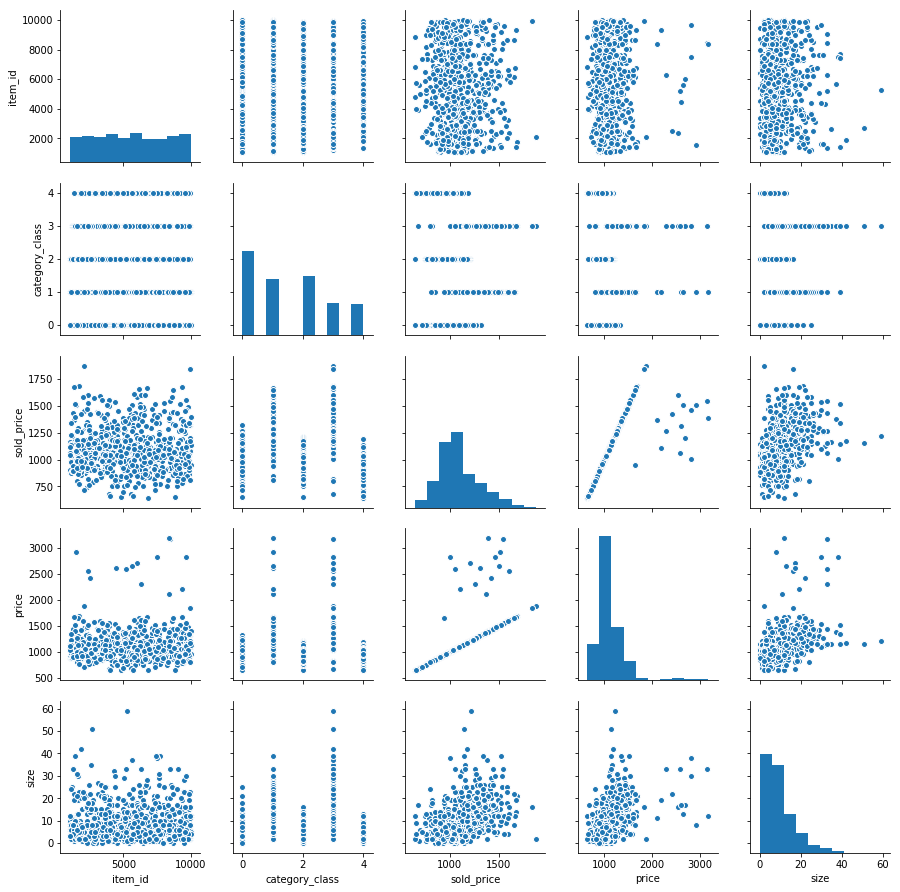

In [56]:
sns.pairplot(train)

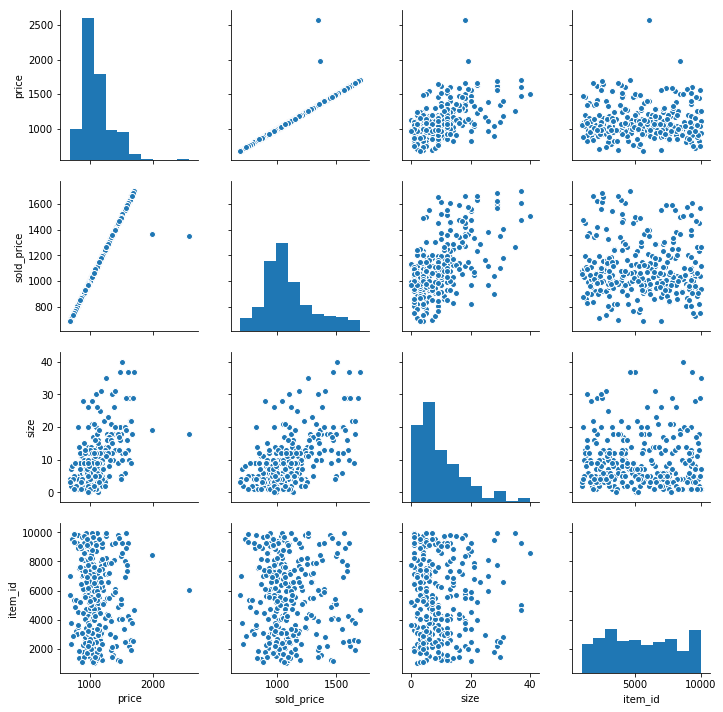

In [18]:
cols = list(set(test.columns) - set(['category_class']))
sns.pairplot(test[cols])

C:\Users\leo_g\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\leo_g\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


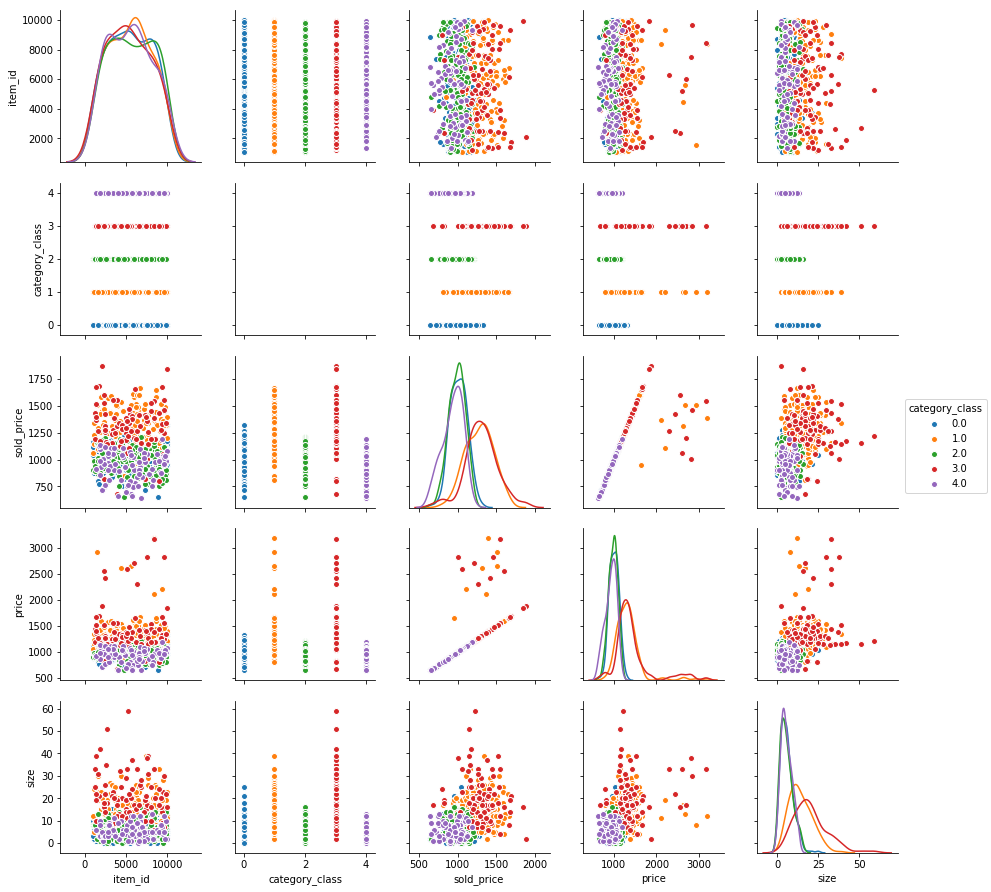

In [23]:
sns.pairplot(train, hue='category_class', diag_kind="kde", size=2.5)

### Conclusion: Something Unusual or Importan?
- Outliers are in the 'price', but they are likely not the wrong measuremnts but the correct numbers for exclusive items.
- Chipper items are more than expensive items, that is also makes sense. 
- 'Item_id' feature is slightly "leaking" into 'category_class' :) So the 'item_id' is important feature in modeling.
- Categoires 1 and 3 are highly similar in 'size', 'price', 'sold_price'. The same is for the categories 0,2,4. So we will get big errors in separating categories inside groups [1, 3] and [0, 2, 4] and much smaller errors between those groups.

## What about distributions inside 'category_class'?

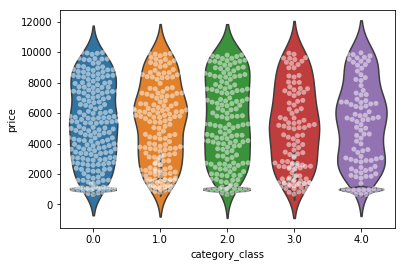

In [29]:
def plot_violin(y_col):
    sns.violinplot(x='category_class', y=y_col, data=train, inner=None)
    sns.swarmplot(x='category_class', y=y_col, data=train, color="w", alpha=.5)
    
plot_violin('item_id')

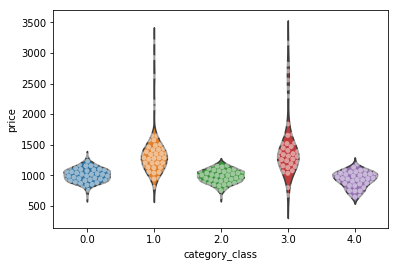

In [30]:
plot_violin('price')

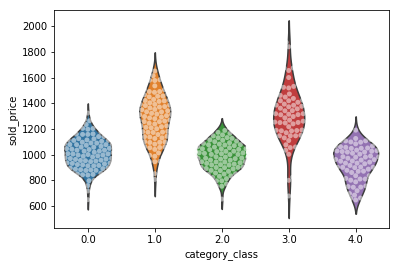

In [31]:
plot_violin('sold_price')

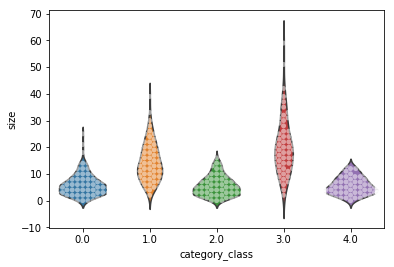

In [32]:
plot_violin('size')

Nothing new here.

# Conclusions
What we can do with data? What data cleaning? What the feature engineering?
- Test and train datasets are balanced. Nothing to do with data balancing.
- Data Cleaning: no work with missing data, with outliers.
- Feature Engineering: Seems the 'price_discount' = 'price' - 'sold_price' could help. Not sure. Let's try. (We do not analyze the 

# Categorical Features
How the 'area_name', 'condition', 'item_tag_hash' related to the 'category_class'.

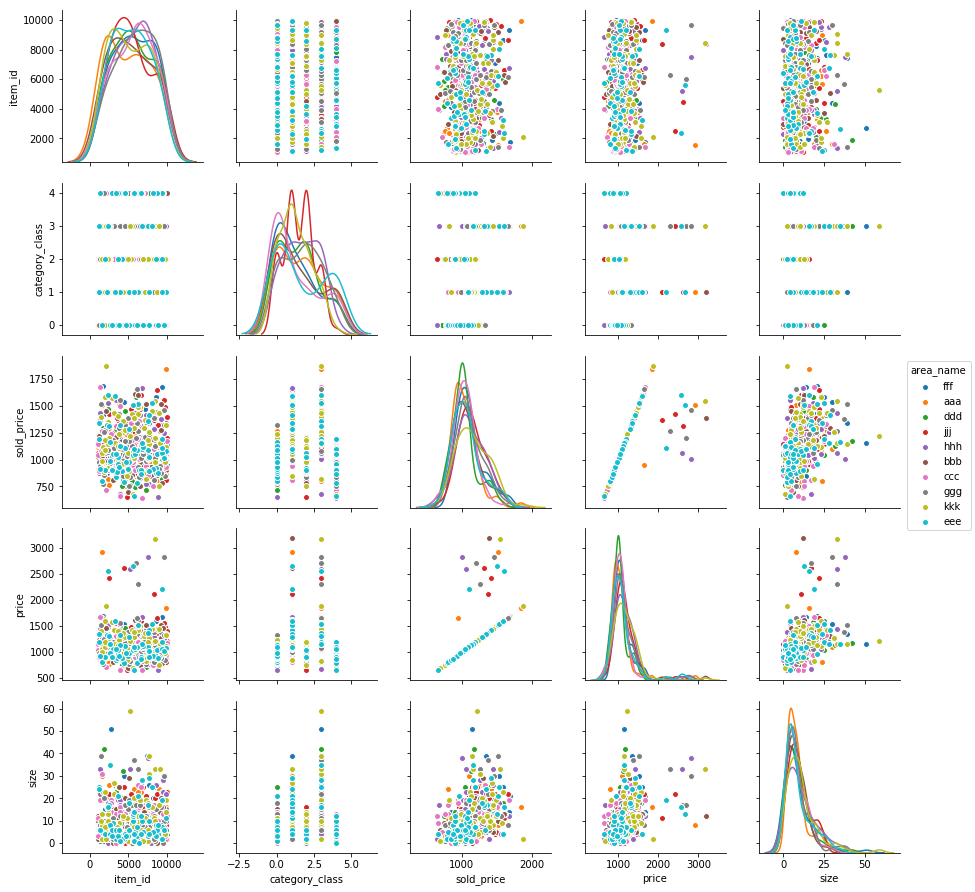

In [47]:
sns.pairplot(train, hue='area_name', diag_kind="kde", size=2.5)

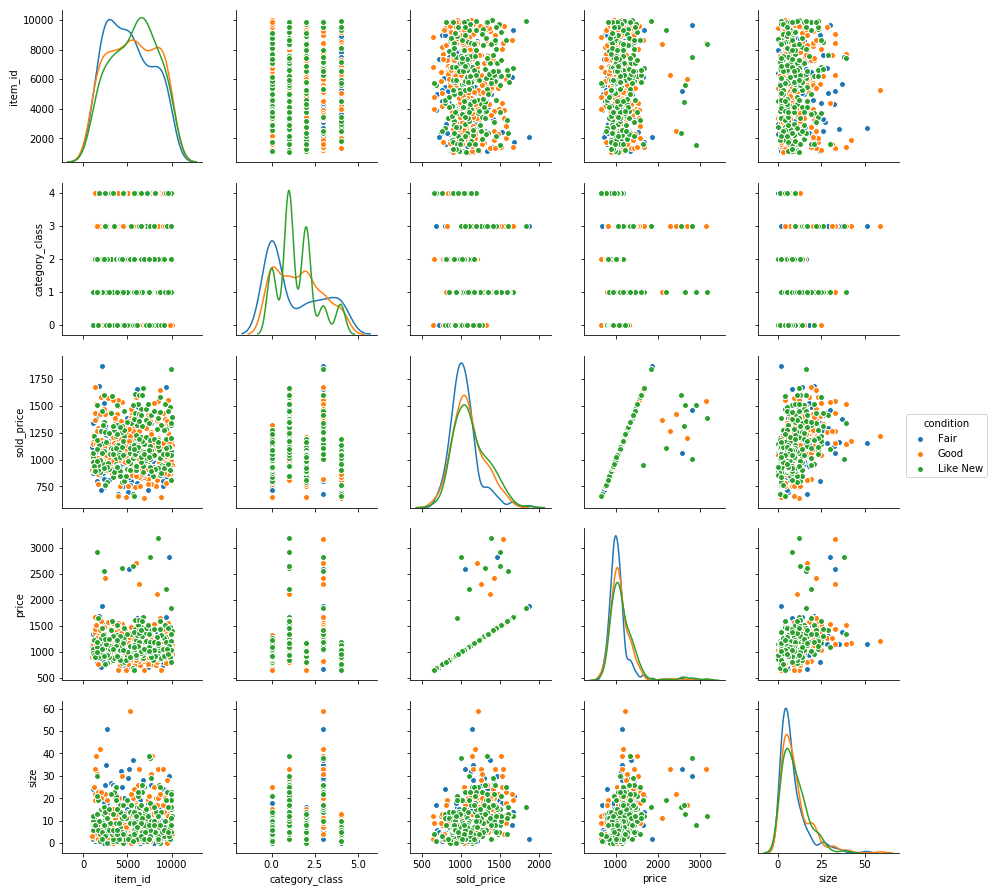

In [48]:
sns.pairplot(train, hue='condition', diag_kind="kde", size=2.5)

## Conclusions: 
- 'condition' and 'area_name' are the clean and important features. 'item_tag_hash' is not suitable for simple visual analysis.

# Datetime Feature
Let's analyze the 'listing_at' field.

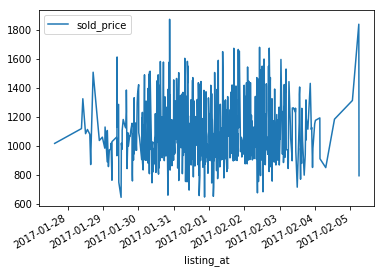

In [59]:
train.plot(x='listing_at', y='sold_price')

In [79]:
print(train.listing_at.min(), train.listing_at.max())
print(test.listing_at.min(), test.listing_at.max())


2017-01-27 15:10:14.057584 2017-02-05 05:59:49.516616
2017-01-27 17:50:51.905022 2017-02-04 13:23:37.979901


### Conclusion:
The 'listing_at' interval is limited to several days. So, seems, the seasonal, holiday features do not make sense. We could try to extract day, weekend, hour, min as the additional features. 

# Is there the equal hashes in train and test?
If we have the equal hashes, do the rows with equal hashes in train and test belong to the same category? It would mean the data leak and finding equal hashes in train and test we find the test category with probability 100%.

In [108]:
train_item_tag_hashes = set(train.item_tag_hash)
test_item_tag_hashes = set(test.item_tag_hash)
intersection_item_tag_hashes = set(train_item_tag_hashes).intersection(test_item_tag_hashes)
print('  Finished creating intersection_item_tag_hashes, len(set) [# of similar items]=' + str(len(intersection_item_tag_hashes)))

  Finished creating intersection_item_tag_hashes, len(set) [# of similar items]=134


In [109]:
df = pd.DataFrame()
for hash in intersection_item_tag_hashes:
    #print(df.shape, train[train.item_tag_hash == hash].shape, test[test.item_tag_hash == hash].shape)
    df = pd.concat([df, train[train.item_tag_hash == hash], test[test.item_tag_hash == hash]], axis=0, ignore_index=True)  
    

In [110]:
df.category_class.fillna(value=9, inplace=True)

In [107]:
df_hash_category = df.groupby(by=['item_tag_hash', 'category_class'], axis=0)
df_hash_category.count()

item_id  sold_price  \
item_tag_hash                            category_class                        
00fd4b4549a1094aae926ef62e9dbd3cdcc2e456 0.0                   3           3   
                                         9.0                   1           1   
0104cf3b45056589309effd4d0889e430018b490 2.0                   5           5   
                                         9.0                   3           3   
0200320ae3bc247e747ef93e3259bc29ddf53392 3.0                   2           2   
                                         9.0                   2           2   
02ef6a4d5e9b6440ee4513baf40746cb8e872fe4 0.0                   1           1   
                                         2.0                   4           4   
                                         9.0                   4           4   
02f84308fab673d8332e1ab780a8ade20987e925 1.0                   1           1   
                                         9.0                   1           1   
04b69e5006d308a60f286c6d87138324d3c745c6 0.0                   7           7   
                                         9.0                   1           1   
070dafcb55881e67b7fce04cfb94faa33639b865 0.0                   2           2   
                                         9.0                   2           2   
071819749594ed380380dca6aed0f24e25cc9269 2.0                   3           3   
                                         9.0                   1           1   
081be7c370bf9e7b4c6e696276c1b2d57623b26b 1.0                   4           4   
                                         9.0                   2           2   
0aec17ce3bff113e1c7c16e9d9dcaf90bf590974 3.0                   3           3   
                                         9.0                   2           2   
0cf950b5e4d2ebd7c978c76091ddce6176845697 2.0                   3           3   
                                         9.0                   2           2   
0f23eb04fa3d66bce3cb03de0629ac1b4fd32bbb 3.0                   4           4   
                                         9.0                   2           2   
0fb0a8a62cbe899f9c109e5ccf6d5f3b35e33f38 0.0                   3           3   
                                         4.0                   1           1   
                                         9.0                   1           1   
138825ed8f4199d67f9ca400b795b65fec1158ac 0.0                   2           2   
                                         9.0                   2           2   
...                                                          ...         ...   
e0f05ed4fd4ffb1af17b55948173bfe2900cefb4 0.0                   1           1   
                                         9.0                   1           1   
e41c8fd8d6da74a91fc96008280baea77725b5a7 1.0                   4           4   
                                         9.0                   2           2   
e83f7664870c1105727dd99353d0bfa01b2450b5 0.0                   2           2   
                                         9.0                   1           1   
e9a20a4af61c91b0232679bc583058b278fb2926 3.0                   1           1   
                                         4.0                   1           1   
                                         9.0                   3           3   
ec883370694191262ca4364fb7b34135e11947b8 0.0                   1           1   
                                         9.0                   1           1   
eeb8f1dbcd3eedab645d5ab893d199d494579bf3 1.0                   8           8   
                                         9.0                   3           3   
ef9cb1abfdb1d45bb08bd2742f179591c8266187 0.0                   2           2   
                                         9.0                   1           1   
f0a3865870d476fd2019497ce810af59b1f3581b 1.0                   7           7   
                                         2.0                   1           1   
                                         9.0             

### Conclusion
There are many equal hashes in train and test. But the equal hashes in train belong to rows with differen categories. That means no direct link between hash and category and we cannot use equal hash for finding categories in test.

# Is there the equal id-s in train and test?
If we have the equal id-s, do the rows with equal id-s in train and test belong to the same category? 
It would mean the data leak and finding equal id-s in train and test we find the test category with probability 100%.

In [96]:
train_item_id = set(train.item_id)
test_item_id = set(test.item_id)
intersection_item_id = set(train_item_id).intersection(test_item_id)
print('  Finished creating intersection_item_id, len(set) [# of similar items]=' + str(len(intersection_item_id)))


  Finished creating intersection_item_id, len(set) [# of similar items]=0


### Conclusion
There are zero equal id-s in train and test and no data leak.